In [111]:
## Main SWR detection analysis! Note there are two ways to analyze the data: a cluster and local version. I keep them
## both updated with changes for now since I tend to check with the local version even if the cluster version is better
## for bulk analysis 2020-6-17 JS
## Updated for catFR1 analysis 2020-09-29 JS. Largely edited for manually removing bad electrodes 
## (search for catFR1 in CLUSTER get for example)

In [2]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

import seaborn as sb

df = get_data_index("r1") # all RAM subjects
exp = 'FR1' # 'FR1' 'catFR1'

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# sub lists I've been using to explore FR1 

subs = ['R1010J'] #'R1385E'] # ['R1065J'] #
# subs = ['R1002P','R1003P','R1006P','R1010J','R1112M','R1163T'] # initial 6 for hippocampus

# subs = subs+['R1001P','R1092J','R1151E','R1320D'] # additional subs with issues that I resolved with various RR and corr thresholds
# subs = ['R1112M','R1018P','R1020J','R1022J','R1023J','R1026D','R1027J'] # 7 with entorhinal
# subs = ['R1010J','R1112M'] # original 2 # R1108J beatiful catFR1 data; R1065J magical subject (like with FR1)
# subs = ['R1112M','R1163T'] # subjects with FR1 and catFR1. SRs of 1000 and 500 tho
# subs = ['R1151E'] # all channels X sessions get removed but 3 after 60/180 hz line removal
# these should all be worked out now. See SWR FR1 problem sessions PPT on Box for details of each
# subs = ['R1299T','R1332M','R1397D','R1349T','R1339D','R1337E','R1275D','R1151E','R1123C','R1120E','R1045E'] # final surrounding_recall problem subs after looking at huge raster!
# subs = ['R1308T','R1338T','R1358T'] # these guys had weird SRs and some loading problems when I went to whole_retrieval analysis...fixed with rounding
# subs = ['R1023J','R1101T','R1148P','R1368T','R1323T','R1334T'] # single session subs with memory allocation errors in ClusterRun
# subs = ['R1006P','R1010J','R1030J','R1032D','R1049J','R1051J','R1052E','R1054J','R1093J','R1098D','R1104D','R1108J','R1111M',
#         'R1115T','R1118N','R1124J','R1207J','R1230J','R1316T','R1329T','R1323T','R1337E','R1367D'] # subs that didn't load on 2020-07-04 encoding run
# subs = ['R1368T','R1461T','R1463E'] # subs with particularly low localization.pair matches in pairs...see Excel in loading info on Box for details
# subs = ['R1433E','R1355T','R1367D','R1368T'] # subs with "ca3" or "dg"
# subs = ['R1001P'] # subject with over 8000 FR1 trials X electrodes
# bad_subs = ['R1433E','R1051J'] # no electrode cats
# subs = ['R1379E','R1385E','R1387E','R1394E','R1402E'] # partial beep subs
# subs = ['R1379E','R1402E','R1396T','R1395M','R1415T','R1389J','R1404E']  # test subs for eeg offset correction
# subs = ['R1054J','R1345D','R1048E','R1328E','R1308T', # first 2 are sr ≥ 1000. 3rd is 500 Hz.
#         'R1137E','R1136N','R1094T','R1122E','R1385E', # nice example FR1 subs used in Fig. 2
#         'R1405E','R1486J','R1501J'] # adding in 3 catFR only patients that will go into Fig. 4
# subs = ['R1120E','R1349T','R1397D','R1332M','R1299T'] # FR1 patients with electrode search ranges limited per SWR problem sessions doc on Box
# subs = ['R1269E','R1328E','R1367D','R1397D','R1405E','R1405E','R1447M','R1469D'] # catFR1 patients with electrode search changes limited
# subs = ['R1345D']

sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp)] # all sessions for subs
# sub_df = df[(df.subject.isin(subs))  & (df.experiment == exp) & (df.session==1)] # single session
# sub_df = df[(df.experiment == exp) & (df.session == 0)] # all FR subs 
# sub_df = sub_df[5:]
sub_df

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
37,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,0,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...
38,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...,protocols/r1/subjects/R1010J/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1010J/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1010J/localizations/0/m...,NaN,1,R1010J,R1010J,NaN,protocols/r1/subjects/R1010J/experiments/FR1/s...


In [4]:
# 575 FR sessions. first 18 of don't load so skip those 
exp_df = df[df.experiment==exp]
if exp == 'FR1':
    exp_df = exp_df[
                    ((df.subject!='R1015J') | (df.session!=0)) & 
                    ((df.subject!='R1063C') | (df.session!=1)) & 
                    ((df.subject!='R1093J') | (~df.session.isin([1,2]))) &
                    ((df.subject!='R1100D') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1120E') | (df.session!=0)) &
                    ((df.subject!='R1122E') | (df.session!=2)) &
                    ((df.subject!='R1154D') | (df.session!=0)) &
                    ((df.subject!='R1186P') | (df.session!=0)) &
                    ((df.subject!='R1201P') | (~df.session.isin([0,1]))) &
                    ((df.subject!='R1216E') | (~df.session.isin([0,1,2]))) &
                    ((df.subject!='R1277J') | (df.session!=0)) &
                    ((df.subject!='R1413D') | (df.session!=0)) & 
                    ((df.subject!='R1123C') | (df.session!=2)) & # artifacts that bleed through channels (see SWR FR1 prob sessions ppt)
                    ((df.subject!='R1151E') | (~df.session.isin([1,2]))) & # more bleed-through artifacts (see same ppt)
                    ((df.subject!='R1275D') | (df.session!=3))  # 3rd session an actual repeat of 2nd session (Paul should have removed from database by now)
    #                 (df.subject!='R1065J') # sub with 9000 trials
                   ] 
if exp == 'catFR1': 
    exp_df = exp_df[
                    ((df.subject!='R1044J') | (df.session!=0)) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1491T') | (~df.session.isin([1,3,5]))) & # too few trials to do pg pairwise corr
                    ((df.subject!='R1486J') | (~df.session.isin([4,5,6,7]))) & # repeated data...will be removed at some point... @@
                    ((df.subject!='R1501J') | (~df.session.isin([0,1,2,3,4,5]))) & # these weren't catFR1 (and they don't load right anyway)
                    ((df.subject!='R1235E') | (df.session!=0)) & # split EEG filenames error...documented on Asana
                    ((df.subject!='R1310J') | (df.session!=1)) & # session 1 is just a repeat of session 0
                    ((df.subject!='R1239E') | (df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)
    ]
exp_df.shape
# exp_df = exp_df[257:] # for catFR1 this is R1385E-onwwards
# exp_df = exp_df[472:] # for FR1 this is R1385E-onwwards
# exp_df = exp_df[-19:]
exp_df

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


(565, 17)

,Recognition,all_events,contacts,experiment,import_type,localization,math_events,montage,original_experiment,original_session,pairs,ps4_events,session,subject,subject_alias,system_version,task_events
0,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,0,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
1,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...,protocols/r1/subjects/R1001P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1001P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1001P/localizations/0/m...,NaN,1,R1001P,R1001P,NaN,protocols/r1/subjects/R1001P/experiments/FR1/s...
9,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,0,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
10,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...,protocols/r1/subjects/R1002P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1002P/experiments/FR1/s...,0,NaN,1,protocols/r1/subjects/R1002P/localizations/0/m...,NaN,1,R1002P,R1002P,NaN,protocols/r1/subjects/R1002P/experiments/FR1/s...
17,NaN,protocols/r1/subjects/R1003P/experiments/FR1/s...,protocols/r1/subjects/R1003P/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1003P/experiments/FR1/s...,0,NaN,0,protocols/r1/subjects/R1003P/localizations/0/m...,NaN,0,R1003P,R1003P,1.0,protocols/r1/subjects/R1003P/experiments/FR1/s...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525,NaN,protocols/r1/subjects/R1565T/experiments/FR1/s...,protocols/r1/subjects/R1565T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1565T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1565T/localizations/0/m...,NaN,0,R1565T,R1565T,1.0,protocols/r1/subjects/R1565T/experiments/FR1/s...
2535,NaN,protocols/r1/subjects/R1569T/experiments/FR1/s...,protocols/r1/subjects/R1569T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1569T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1569T/localizations/0/m...,NaN,0,R1569T,R1569T,1.0,protocols/r1/subjects/R1569T/experiments/FR1/s...
2540,NaN,protocols/r1/subjects/R1571T/experiments/FR1/s...,protocols/r1/subjects/R1571T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1571T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1571T/localizations/0/m...,NaN,0,R1571T,R1571T,1.0,protocols/r1/subjects/R1571T/experiments/FR1/s...
2544,NaN,protocols/r1/subjects/R1572T/experiments/FR1/s...,protocols/r1/subjects/R1572T/localizations/0/m...,FR1,build,0,protocols/r1/subjects/R1572T/experiments/FR1/s...,0,NaN,NaN,protocols/r1/subjects/R1572T/localizations/0/m...,NaN,0,R1572T,R1572T,1.0,protocols/r1/subjects/R1572T/experiments/FR1/s...


## Load CLUSTER data

In [24]:
## Now to load data from cluster, have to go through and append across sessions

### params that clusterRun used (note that exp is defined in first cell so can get exp_df above)

selected_period = 'whole_encoding'
# 'whole_encoding': aligned to 1st word of each encoding period and ends 29.7 s later (average time for 12 words to be shown)
# 'encoding': aligned to word_on

recall_type_switch = 0

recall_minimum = 0 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math
sub_selection = 'first_half' # 'second_half', 'whole' ,'first_half'
                              # analyze first 40%, remaining 60% of data, or whole? 
                              # works for FR1 and catFR1
###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

analysis_df = getSplitDF(exp_df,sub_selection,exp)

for row in analysis_df.itertuples(): #analysis_df.itertuples(): #sub_df.itertuples():  #analysis_df.itertuples(): 
    try:
        sub = row.subject; session = row.session; exp = row.experiment

        path_name = '/scratch/john/SWR_scratch/'+subfolder
        fn = os.path.join(path_name,
            'SWR_'+exp+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                          '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
        with open(fn,'rb') as f:
            dat = pickle.load(f)

            ripple_array = superVstack(ripple_array,dat['ripple_array']) 
            region_electrode_ct.append(dat['region_electrode_ct'])
            encoded_word_key_array.extend(dat['encoded_word_key_array'])
            HPC_names.extend(dat['HPC_names'])
            sub_sess_names.extend(dat['sub_sess_names'])
            sub_names.extend(dat['sub_names'])
            trial_nums = np.append(trial_nums,dat['trial_nums'])
            trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
            elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
            elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
            #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)

            
            # specific to whole_encoding
            serialpos_array.extend(dat['serialpos_array'])
            recall_position_array.extend(dat['recall_position_array'])
            list_recall_num_array.extend(dat['list_recall_num_array'])
            
            electrode_labels.extend(dat['electrode_labels'])
            channel_coords.extend(dat['channel_coords'])
            channel_nums.extend(dat['channel_nums'])
            list_num_key.extend(dat['list_num_key'])
            
    except Exception as e:
        LogDFExceptionLine(row, e, 'ClusterLoadSWR_log.txt')  
print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

# temp_recall_idxs = np.array(list_recall_num_array)>=0 # just keep them all
    
# subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
# session_name_array = np.array(session_name_array)[temp_recall_idxs]
# electrode_array = np.array(electrode_array)[temp_recall_idxs]
# channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
# channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
# ripple_array = np.array(ripple_array)[temp_recall_idxs]
# rectime_array = np.array(rectime_array)[temp_recall_idxs]
# list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
# recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
    
print('**Done translating to ripple_array frame**!!')
print('...')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

# some info about regions 
print('Total electrodes: '+str(len(HPC_names)))
unique_names = np.unique(HPC_names); print(unique_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
# channel_nums

['R1325C' 'R1310J' 'R1077T' 'R1288P' 'R1044J' 'R1108J' 'R1002P' 'R1131M'
 'R1316T' 'R1215M']
['R1306E' 'R1137E' 'R1105E' 'R1048E' 'R1138T' 'R1122E' 'R1094T' 'R1236J'
 'R1120E' 'R1338T']
2021-09-22_17-58-02: DF Exception: Sub: R1067P, Sess: 0, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/WHOLE_ENCODING/SWR_FR1_R1067P_0_HPC_whole_encoding_soz_in_hamming.p', file: <ipython-input-24-c0c41e592bb5>, line no: 51
2021-09-22_17-58-02: DF Exception: Sub: R1067P, Sess: 2, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/WHOLE_ENCODING/SWR_FR1_R1067P_2_HPC_whole_encoding_soz_in_hamming.p', file: <ipython-input-24-c0c41e592bb5>, line no: 51
2021-09-22_17-58-06: DF Exception: Sub: R1120E, Sess: 1, FileNotFoundError, [Errno 2] No such file or directory: '/scratch/john/SWR_scratch/WHOLE_ENCODING/SWR_FR1_R1120E_1_HPC_whole_encoding_soz_in_hamming.p', file: <ipython-input-24-c0c41e592bb5>, line no: 51
2021-09-22_17-58-07: DF Excepti

(10881, 15850)

From 115/119 sessions with >0 HPC electrodes
Total electrodes: 512
Length of HPC names: 512
Total trials: 10881.0
Unique sessions: 115
Unique subjects: 56
Total electrodes: 512
['left ca1' 'left ca2' 'left ca3' 'left dg' 'left hippocampus' 'left sub'
 'right ca1' 'right dg' 'right hippocampus' 'right sub']
153 for left ca1
7 for left ca2
8 for left ca3
123 for left dg
30 for left hippocampus
19 for left sub
90 for right ca1
45 for right dg
15 for right hippocampus
22 for right sub


(10881, 15850)


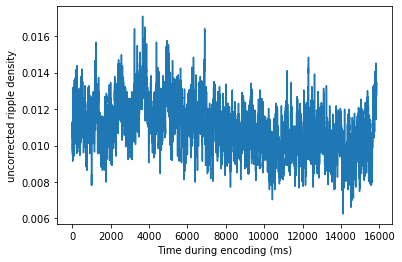

In [25]:
print(np.shape(ripple_array))
plot(np.mean(ripple_array,0))
ylabel('uncorrected ripple density')
xlabel('Time during encoding (ms)');

## to visualize the removal parameters

/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


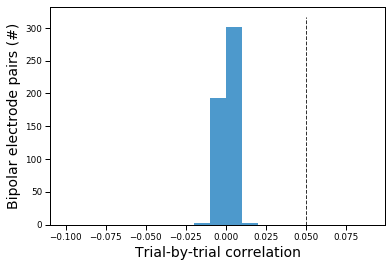

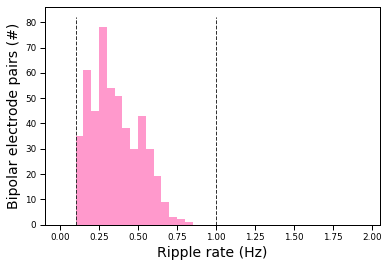

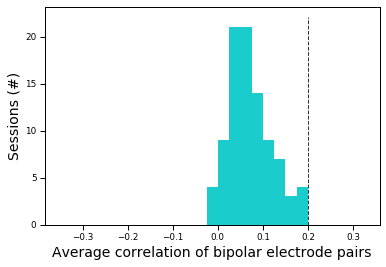

In [6]:
save_figs = 0
# np.array(trial_by_trial_correlation)
# np.array(elec_ripple_rate_array)
# np.array(elec_by_elec_correlation)
set_pubfig()

# trial-by-trial correlation
plt.hist(trial_by_trial_correlation,np.arange(-0.1,0.1,0.01),color = (0.3,0.6,0.8)); 
xlabel('Trial-by-trial correlation'); ylabel('Bipolar electrode pairs (#)'); 
plot([0.05,0.05],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/trial-by-trial_correlation.pdf',transparent=True); show()
else:
    show()

# ripple rates
plt.hist(elec_ripple_rate_array,np.arange(0,2,0.05),color = (1,0.6,0.8)); 
xlabel('Ripple rate (Hz)'); ylabel('Bipolar electrode pairs (#)'); 
ylims = [gca().get_ylim()[0],gca().get_ylim()[1]]
plot([0.1,0.1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
plot([1,1],ylims,linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/ripple_rates_by_electrode.pdf',transparent=True); show()
else:
    show()
    
plt.hist(elec_by_elec_correlation,np.arange(-0.35,0.35,0.025),color = (0.1,0.8,0.8)); 
xlabel('Average correlation of bipolar electrode pairs'); ylabel('Sessions (#)'); 
plot([0.2,0.2],[gca().get_ylim()[0],gca().get_ylim()[1]],linewidth=1,linestyle='--',color=(0.2,0.2,0.2),label='_nolegend_')
if save_figs == 1:
    plt.savefig('../figures/control_params/sessions_electrode_correlations.pdf',transparent=True)
show();

#     max_ripple_rate = 3 #1.5 # Hz.
#     max_trial_by_trial_correlation = 1 #0.05 # if ripples correlated more than this remove them
#     max_electrode_by_electrode_correlation = 1 #0.2 #???
#     if filter_type == 'hamming':
#         min_ripple_rate = 0 # 0.1 # Hz.
#     else:
#         min_ripple_rate = 0.05 # for methods with lower rates decrease the minimum cutoff

## Get start_array and select subfield if HPC for free recalls

In [26]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

select_subfield = True   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to False for ENT and PHC
    
# select for subfield if HPC
if select_subfield == True:
    location_selected = 'ca1' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
        # left # right # left hippocampus # right hippocampus # hippocampus
        # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
else:
    location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array); print('Got encoding start_array!')
 
# if selected an output position
if select_ordinal_position > 0:
    if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
        ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
    selected_recalls = ordinal_position_array==select_ordinal_position
elif type(select_list_position) == list:
    selected_recalls = [sp in select_list_position for sp in serialpos_array]
elif select_intrusions_next == 1:
    selected_recalls = np.array(recall_before_intrusion_array)==True
elif select_less_than_rectime > 0:
    selected_recalls = np.array(rectime_array)<select_less_than_rectime
elif select_greater_than_rectime > 0:
    selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
elif type(select_lists_with_recalls) == list:
    selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
else:
    selected_recalls = np.ones(len(start_array),dtype=bool)
    
# get locations if selected

if select_subfield == True:
    # create the full vector of location name predictors
    location_names = []
    for s in range(len(HPC_names)):
        new_trials = int(trial_nums[s])
        location_names.extend(np.tile(HPC_names[s],new_trials))  
        
    # now can get mask of trials in this location
    
    #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
    location_mask = np.zeros(len(location_names))
    for s in range(len(location_names)):
        if type(location_selected)==list:
            if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
                location_mask[s] = True
        elif type(location_selected)==str:
            if location_names[s].find(location_selected)>=0:
                location_mask[s] = True
else:
    location_mask = np.ones(len(start_array))

# DON'T USE temp_recall_idxs FOR ENCODING
# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# combine location and sorted recalls to get new ripple array:
updated_recalls = (location_mask+selected_recalls)==2
    
# translate these predictors to vector and select recalls
start_array = start_array[updated_recalls]
end_array = end_array[updated_recalls] # used for duration calculations
subject_name_array = np.array(subject_name_array)[updated_recalls]
session_name_array = np.array(session_name_array)[updated_recalls]
electrode_array = np.array(electrode_array)[updated_recalls]
channel_coords_array = np.array(channel_coords_array)[updated_recalls]
channel_nums_array = np.array(channel_nums_array)[updated_recalls]
# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
# rectime_array = np.array(rectime_array)[updated_recalls]
# recall_position_array = np.array(recall_position_array)[updated_recalls]

# specific to encoding
# serialpos_array = np.array(serialpos_array)[updated_recalls] # FIX THIS ONCE RUN AGAIN 2021-09-16
list_recall_num_array = np.array(list_recall_num_array)[updated_recalls]
encoded_word_key_array = np.array(encoded_word_key_array)[updated_recalls]
serialpos_array = np.array(serialpos_array)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

print('# of trials: '+str(np.shape(start_array)[0]))
print('Total # of ripples: '+str(sum(start_array)))
print('Overall ripple rate: '+str(np.round( (1000/sr_factor)*sum(start_array)/np.shape(start_array)[0]/np.shape(start_array)[1],3 ))+' Hz')

Total electrodes loaded: 512
from 115 sessions from 56 subjects with trial nums:
[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
 25. 16.]
Trial sum = 10881.0
['left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'left ca3', 'left ca1', 'right sub', 'right ca1', 'right ca1', 'right ca1', 'right dg', 'right dg', 'right sub', 'right sub', 'right ca1', 'left sub', 'left dg', 'left ca1', 'left ca1']
Number of sub_sess names: 512
Got encoding start_array!
Got start_array with 5021 trials!
Number of electrodes: 118
...from 50 patients


## For whole_encoding analysis, for each patient find high and low ripple lists

In [28]:
encoded_word_key_array

array([array([    0,  2434,  4884,  7335,  9885, 12319, 14903, 17304, 19805,
       22254, 24638, 27072]),
       array([    0,  2417,  5034,  7586, 10085, 12652, 15102, 17621, 20220,
       22654, 25138, 27705]),
       array([    0,  2382,  4833,  7400,  9867, 12368, 14868, 17435, 19886,
       22320, 24703, 27087]),
       ...,
       array([    0,  2681,  5399,  8104, 10578, 13049, 15806, 18359, 21022,
       23748, 26314, 28715]),
       array([    0,  2653,  5055,  7770, 10143, 12662, 15142, 17699, 20176,
       22562, 25233, 27841]),
       array([    0,  2600,  5059,  7507, 10077, 12809, 15441, 17847, 20323,
       22979, 25576, 27967])], dtype=object)

In [31]:
# kept encoding period long enough for 12*(1.6)+11*(1.0)=30.2 s

full_encoding_start_array = start_array[:,1000:]

offset = 100 
presentation_time = 1600
offset_sr = offset/sr_factor # offset of when to look at hippocampal data (in samples). E.g. want to look at word presentation from 100:1700 ms.
presentation_sr = presentation_time/sr_factor

print('Length of start_array: '+str(np.round(np.shape(full_encoding_start_array)[1]/1000*2,2)))

high_ripple_correct = []
low_ripple_correct = []
sub_recalls_per_list = []

for sub in np.unique(subject_name_array):
    sub_idxs = [sub in s for s in subject_name_array]
    if sum(sub_idxs) > 1:
        sub_start_array = full_encoding_start_array[sub_idxs]
        sub_subject_name_array = subject_name_array[sub_idxs]
        sub_session_name_array = session_name_array[sub_idxs]
        sub_list_recall_num_array = list_recall_num_array[sub_idxs]
        sub_encoded_word_times = encoded_word_key_array[sub_idxs]
        
        sub_recalls_per_list.append(np.mean(sub_list_recall_num_array)) # record overall recalls/list for sub       

        # this gets you mean values across entirety of retrieval period        
        # 0.875 is average of 0.75-1.0 s and there are 11 ISIs, so this grabs 2.0:30.825 s (first 2 seconds were added for plots)
        ripples_per_list = np.sum(sub_start_array[:,:int(1000+(1600*12/sr_factor)+(875*11/sr_factor))],1)
        median_ripples = np.median(ripples_per_list)
        high_ripple_idxs = findInd(ripples_per_list > median_ripples)
        low_ripple_idxs = findInd(ripples_per_list <= median_ripples)        
        high_ripple_correct.append(np.mean(np.array(sub_list_recall_num_array)[np.array(high_ripple_idxs)])) # recalls/list for sub's high ripple lists
        low_ripple_correct.append(np.mean(np.array(sub_list_recall_num_array)[np.array(low_ripple_idxs)])) # same for low ripple lists
        
        # now want to split up word presentation and ISI periods by ripple rate
        
        for trial_num in range(len(sub_start_array)):
            word_ripple_list = []
            ISI_ripple_list = []
            for i_word,word_time in enumerate(sub_encoded_word_times[trial_num]):
                import ipdb; ipdb.set_trace()
                # note that I already removed the 2 sec initial buffer at top
                word_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+offset_sr): 
                                                            int(word_time/sr_factor+presentation_sr+offset_sr)]))
                if i_word<len(sub_encoded_word_times[trial_num]): # last word doesn't have an ISI afterwards
                    ISI_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+presentation_sr+offset_sr):
                                                               int(sub_encoded_word_times[trial_num][i_word+1]/sr_factor+offset_sr)]))
            
        
        a=1
plot(np.mean(full_encoding_start_array,0))

Length of start_array: 28.82
--Call--
> /home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/IPython/core/displayhook.py(252)__call__()
    251 
--> 252     def __call__(self, result=None):
    253         """Printing with history cache management.



ipdb>  u


> <ipython-input-31-5208b1d08820>(40)<module>()
     39             ISI_ripple_list = []
---> 40             import ipdb; ipdb.set_trace()
     41             for i_word,word_time in enumerate(sub_encoded_word_times[trial_num]):



ipdb>  trial_num


0


ipdb>  int(word_time/sr_factor+offset_sr)


*** NameError: name 'word_time' is not defined


ipdb>  b 42


Breakpoint 1 at <ipython-input-31-5208b1d08820>:42


ipdb>  c


> <ipython-input-31-5208b1d08820>(42)<module>()
     41             for i_word,word_time in enumerate(sub_encoded_word_times[trial_num]):
1--> 42                 word_ripple_list.append(sum(sub_start_array[trial_num, int(word_time/sr_factor+offset_sr): 
     43                                                             int(word_time/sr_factor+presentation_sr+offset_sr)]))



ipdb>  int(word_time/sr_factor+offset_sr)


50


ipdb>  np.shape(sub_start_array)


(150, 14412)


ipdb>  q


BdbQuit: 

Low ripples:
[4.62962963 3.26666667 3.         1.26923077 7.12       6.19230769
 3.47474747 3.71875    2.51851852 1.34210526 3.         3.15384615
 2.67647059 1.9137931  5.10666667 3.77593361 4.06363636 3.59210526
 1.92857143 2.07692308 3.54545455 3.46153846 3.48837209 2.41269841
 3.46666667 1.25       4.43137255 2.76       1.17647059 3.39240506
 0.75      ]
High ripples:
[4.47826087 3.1        2.         0.83333333 6.64       6.64285714
 3.39473684 2.96875    2.73076923 1.43243243 0.         2.91666667
 2.03571429 1.02173913 4.9        3.4679803  4.27777778 3.44594595
 2.36363636 2.6        4.25806452 3.75       2.46875    2.32432432
 5.2        1.         4.32653061 1.70833333 1.16666667 2.98591549
 0.68181818]
['R1020J' 'R1022J' 'R1033D' 'R1034D' 'R1048E' 'R1056M' 'R1065J' 'R1080E'
 'R1083J' 'R1094T' 'R1096E' 'R1102P' 'R1108J' 'R1112M' 'R1122E' 'R1137E'
 'R1154D' 'R1168T' 'R1203T' 'R1215M' 'R1217T' 'R1221P' 'R1236J' 'R1243T'
 'R1293P' 'R1306E' 'R1310J' 'R1311T' 'R1325C' 'R1334T' 'R1

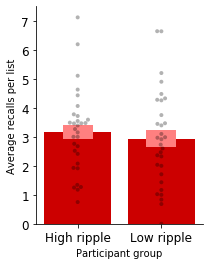

In [27]:
## high v. low recall patients

if location_selected == 'dg':
    min_rate = 0.1
    plot_color = [(0.8,0,0)]
    lmplot_color = (0.8,0,0,0)
    errorbar_color = (1,0.5,0.5)
    line_color = 'darkred'
elif region_name == 'ENT':
    min_rate = 0.0 # for ENT and PHC I don't do further stats so just set to 0 to show all the datapoints in the swarm
    plot_color = [(0.5,0.5,0)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0.8,0.8,0)
    line_color = 'black'
elif region_name == 'PHC':
    min_rate = 0.0
    plot_color = [(0,0.5,0.5)]
    lmplot_color = (0,0,0,0)
    errorbar_color = (0,0.8,0.8)
    line_color = 'black' 
elif location_selected == 'ca1' or location_selected == '':
    min_rate = 0.1 # for CA1 and DG I require a FR minimum for the two bins being compared since I do further stats on them
    plot_color = [(0,0,0.8)]
    lmplot_color = (0,0,0.8,0)
    errorbar_color = (0.5,0.5,1)
    line_color = 'darkblue'


plot_df = pd.DataFrame({'low_high_correct':np.concatenate((low_ripple_correct,high_ripple_correct)),
                        'idxs':np.concatenate((np.zeros(len(low_ripple_correct)),np.ones(len(high_ripple_correct))))
                        })

mean_correct = [np.mean(low_ripple_correct),np.mean(high_ripple_correct)]
ste_correct = [np.std(low_ripple_correct)/np.sqrt(len(low_ripple_correct)),np.std(high_ripple_correct)/np.sqrt(len(high_ripple_correct))]

figSub,axSub = plt.subplots(1,1, figsize=(3,4))
# axSub.bar(range(split_into),mean_ripples,yerr=ste_ripples,color=plot_color)
bar(range(2),mean_correct,yerr=ste_correct,color=plot_color,error_kw=dict(lw=30, capsize=0, capthick=0, ecolor=errorbar_color))

# changes from Mike
gca().spines['right'].set_visible(False)
gca().spines['top'].set_visible(False)

add_swarm = 1
if add_swarm == 1:
    extra = '_swarm'
    sb.swarmplot(x='idxs',y='low_high_correct',data=plot_df, ax=axSub, color=(0,0,0), alpha=0.3, size=4)
    axSub.set(ylim=(0,7.5))
    ytick_range = np.arange(0,7.5)
    ylabel(u'Average recalls per list')
else:
    ylim(0,0.175)
    ytick_range = np.arange(0,0.151,0.05)
    extra = ''
    
yticks(ytick_range,fontsize=12)
xticks([1,0],{'Low ripple','High ripple'},fontsize=12) # somehow these are reversed but the high patients have high ripples (see the means below)]
xlabel('Participant group')

# check out accuracy rates v. subjects
print('Low ripples:')
print(np.array(low_ripple_correct))
print('High ripples:')
print(np.array(high_ripple_correct))
print(np.unique(subject_name_array))

t_p = stats.ttest_rel(low_ripple_correct,high_ripple_correct)
print('Paired t-test: p='+str(np.round(t_p[1],3))+', t='+str(np.round(t_p[0],2)))

a=1;

## Subject-level memory performance

# subject-level plots

## Big Raster!!

(14914, 2000)


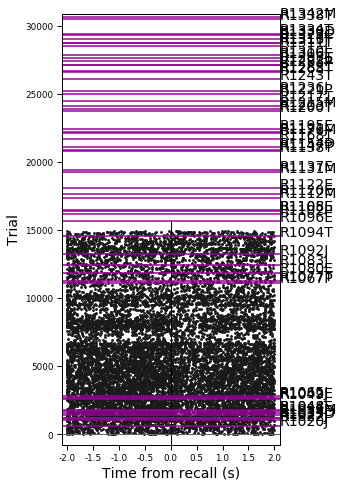

In [10]:

## for the raster and PSTH binarize the data by using the start indices of the ripple

save_raster = 0

elec_dividers_on = 0 # toggles light gray lines between electrodes
session_dividers_on = 0

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6)
between_session_color = (0,0.6,0.6)

encoding_whole_time = 1000*np.round(12*(1.6+0.875),1)

%autoreload
psth_start = -2000
psth_end = encoding_whole_time #2000

# plot raster
subplots(1,1,figsize=(8,20))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a
scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(1,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(2100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(2100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

## Do we see more SWRs during successful encoding? (come here after loading 'encoding' and getting start_array)

In [84]:
# get start_array and masks to identify SME

desired_sample_rate = 500.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

# get vectors of encoding list identifier data for forgotten and recalled words
# in encoded_word_key_array, 0 for not recalled, 1 for recalled, 2 for recalled but was an IRI<2 (don't care about that for encoding)
master_key = encoded_word_key_array>0 # keep all recalls

start_array_enc_forgot = start_array[master_key==0]
start_array_enc_recalled = start_array[master_key==1]

# same for sub and sess
sub_forgot = np.array(subject_name_array)[master_key==0]
sess_forgot = np.array(session_name_array)[master_key==0]
sub_recalled = np.array(subject_name_array)[master_key==1]
sess_recalled = np.array(session_name_array)[master_key==1]

done making binned start_array with shape:
(14696, 26)
SEs created!
done making binned start_array with shape:
(38974, 26)
SEs created!
/home1/john/SWR/figures/ENCODING/SWR_FR1_HPC_ca1_0_soz_in_hamming_first_half.p
Test 1 p-value: 0.00026878368550786437
Test 2 p-value: 0.5855831061006906
53670 trials


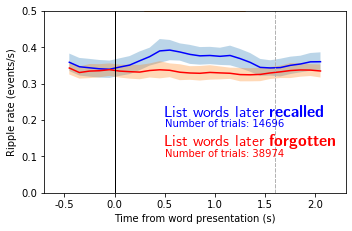

In [85]:
save_plot_data = 1

%autoreload
# get PSTH for recalled and then forgotten words. 
# Then bin it for the CIs and plot each
# then do ME stats on seleted bins and add significance bars if p<0.05

encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700

bin_size = 100 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        subplots(1,1,figsize=(5,4))
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (1,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array,bin_size,smoothing_triangle,sr,pre_encoding_time)
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
#     boot_samples = bootstrap(temp_start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                    bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
#     boot_SD = np.std(boot_samples,0)

    # get binned start array (trials X bins)
    binned_start_array = binBinaryArray(temp_start_array,bin_size,sr_factor)
    if pad > 0:
        binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
    print('done making binned start_array with shape:')
    print(binned_start_array.shape)

    # note that output is the net ± distance from mean
    SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
    print('SEs created!')
    
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
    
    if category == 0:
        PSTH_recalled = copy(PSTH)
        SE_recalled = copy(SE_plot)
    else:
        PSTH_forgotten = copy (PSTH)
        SE_forgotten = copy(SE_plot)

# now that we have the plot with CIs, do stats on key bins. Note here just looking at single bins but comparing across categories
for test in range(2):
    if test == 0:
        first_start = 300
        first_end = 1300
    else:
        first_start = 1700 # same idea but for post-encoding period (ILI)
        first_end = 2300 
        
    bin_test_range = range(int( ((first_start-pre_encoding_time)/sr_factor) ),
                           int( ((first_end-pre_encoding_time)/sr_factor) ))
    binned_recalled_array = start_array_enc_recalled[:,bin_test_range]
    binned_forgot_array = start_array_enc_forgot[:,bin_test_range]
    
    stats_bin = int(first_end-first_start)
    binned_recalled_array = binBinaryArray(binned_recalled_array,stats_bin,sr_factor) # should be creating vectors for both
    binned_forgot_array = binBinaryArray(binned_forgot_array,stats_bin,sr_factor)
    
    bin_model = MEstatsAcrossCategories(binned_recalled_array,binned_forgot_array,
                                        sub_forgot,sess_forgot,sub_recalled,sess_recalled)
    
        # plot bands of significance
    if bin_model.pvalues[1] < 0.05:
        plot([first_end-stats_bin,first_end],[0.5,0.5],color=(1,0.5,0))
    
    if test == 0:
        bin_model1 = copy(bin_model)
        binned_recalled_array1 = copy(binned_recalled_array)
        binned_forgot_array1 = copy(binned_forgot_array)
    else:
        bin_model2 = copy(bin_model)
        binned_recalled_array2 = copy(binned_recalled_array)
        binned_forgot_array2 = copy(binned_forgot_array)
num_trials = len(master_key) 


# get directories for if you save (don't put this in save_plot_data below since want p-values printed at bottom close to figures)
soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
path_name = '/home1/john/SWR/figures/'+subfolder

fn = os.path.join(path_name,
    'SWR_'+exp+'_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
print(fn)
print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(num_trials)+' trials')    
        
if save_plot_data == 1:
    # get strings for path name for save and loading cluster data
            
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH_recalled':PSTH_recalled,'PSTH_forgotten':PSTH_forgotten,
                    'SE_recalled':SE_recalled,'SE_forgotten':SE_forgotten,'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_recalled_array1':binned_recalled_array1,'binned_forgot_array1':binned_forgot_array1,
                    'binned_recalled_array2':binned_recalled_array2,'binned_forgot_array2':binned_forgot_array2,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array,
                    'master_key':master_key}, f) 
        # master_key is indicator for subsequently remembered and forgotten. Can get num_trials from it too
a=1;

## just to remake plot

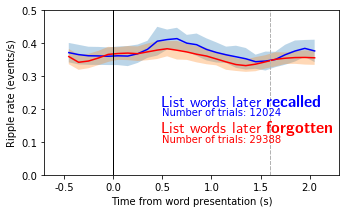

In [81]:
subplots(1,1,figsize=(5,3.375))

# for recalled and then forgotten words
for category in range(2):
    if category == 0:
        temp_start_array = start_array_enc_recalled
        subject_name_array = sub_recalled
        session_name_array = sess_recalled
        
        # for plot
        label = 'List words later \\textbf{recalled}'
        plot_color = (0,0,1)
        text(500,0.21,label,usetex=True,size=16,color=plot_color)
        text(500,0.18,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
        PSTH = copy(PSTH_recalled)
        SE_plot = copy(SE_recalled)

    else:       
        temp_start_array = start_array_enc_forgot
        subject_name_array = sub_forgot
        session_name_array = sess_forgot
        
        # for plot
        label = 'List words later \\textbf{forgotten}'        
        plot_color = (1,0,0)
        text(500,0.13,label,usetex=True,size=16,color=plot_color) 
        text(500,0.10,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
        
        PSTH = copy(PSTH_forgotten)
        SE_plot = copy(SE_forgotten)
        
    # plot
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    xr = xr[pad:-pad]; 
    PSTH = PSTH; #boot_SD = boot_SD[pad:-pad]
    plot(xr,PSTH[pad:-pad],color=plot_color)
    fill_between(xr, PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    tight_layout()
    ax = plt.gca()
    ylim = 0.5
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time,encoding_time)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0))
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7))
a=1;


## encoding ripples by serial position

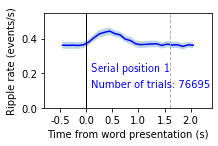

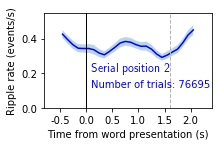

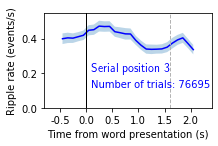

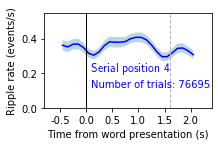

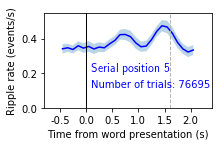

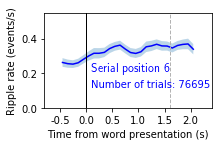

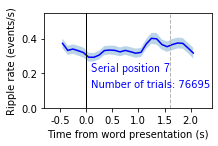

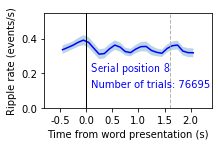

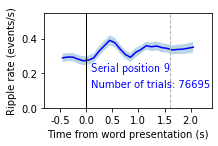

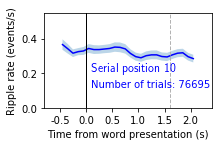

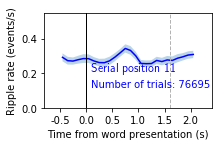

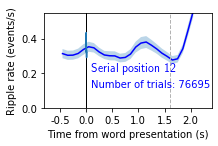

In [12]:
## plot recalled events by serial position

bin_range_to_compare = range(8,18) # this is 100:1100 ms 
# bin_range_to_compare = range(24,29) # this is 1700:2200 ms

binsize = 100 # in ms

ct = 0
serial_position_rem_rates = []
serial_position_rem_stds = []
position_rem_stds = []
serial_position_forgot_rates = []
serial_position_forgot_stds = []
tion_forgot_stds = []
num_recalled = []; num_forgot = []
for list_num in range(12):
    
    temp_start_array_rem = start_array_enc[(master_key==1) & (serial_positions==(list_num+1))]
    temp_start_array_forgot = start_array_enc[(master_key==0) & (serial_positions==(list_num+1))]
    
    subplots(1,1,figsize=(3,1.75))
    label = 'Serial position '+str(list_num+1)
    plot_color = (0,0,1)
    text(100,0.21,label,usetex=True,size=12,color=plot_color)
    text(100,0.12,'Number of trials: '+str(temp_start_array.shape[0]),color=plot_color)
    ct+=temp_start_array.shape[0]    
    # make a PSTH based on start times of SWRs

    PSTH,bin_centers = fullPSTH(temp_start_array_rem,binsize,smoothing_triangle,sr,pre_encoding_time)
    PSTH_forgot,bin_centers = fullPSTH(temp_start_array_forgot,binsize,smoothing_triangle,sr,pre_encoding_time)
    
    # bootstraps error bars by sampling from trials in raster with replacement samples number of
    # times and then taking the standard deviation across those samples
    boot_samples = bootstrap(temp_start_array_rem, bootnum=samples, samples=None, # bootstrap error bars using resampling
                   bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,pre_encoding_time))
    boot_SD = np.std(boot_samples,0)
    
    xr = bin_centers #np.arange(psth_start,psth_end,binsize)
    
    # plot
    plot(xr[pad:-pad],PSTH[pad:-pad],color=plot_color)
    fill_between(xr[pad:-pad], (PSTH+boot_SD)[pad:-pad], (PSTH-boot_SD)[pad:-pad], alpha = 0.3)
    xticks(np.arange(pre_encoding_time+pad*100,encoding_time-pad*100+1,500),
           np.arange((pre_encoding_time+pad*100)/1000,(encoding_time-pad*100)/1000+1,500/1000))
    xlabel('Time from word presentation (s)')
    ylabel('Ripple rate (events/s)')
    ax = plt.gca()
    ylim = 0.55
    ax.set_ylim(0,ylim)
    ax.set_xlim(pre_encoding_time-100,encoding_time+100)
    plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
    plot([1600,1600],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='--',color=(0.7,0.7,0.7));
#     plot([ax.get_xlim()[0],ax.get_xlim()[1]],[0.4,0.4],linewidth=1,linestyle='--',color=(0.5,0.5,0.5));

    # save data for full serial position plot below
    serial_position_rem_rates.append(np.mean(PSTH[bin_range_to_compare]))
    serial_position_rem_stds.append(np.std(PSTH[bin_range_to_compare]))
    serial_position_forgot_rates.append(np.mean(PSTH_forgot[bin_range_to_compare]))
    serial_position_forgot_stds.append(np.std(PSTH_forgot[bin_range_to_compare]))
    num_recalled.append(temp_start_array_rem.shape[0])
    num_forgot.append(temp_start_array_forgot.shape[0])
plot(serial_position_rem_rates)    
a=1;

In [ ]:
# create the general figure
fig1 = figure()
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)

xr=np.arange(1,13)
line1 = errorbar(xr,serial_position_rem_rates,serial_position_rem_stds) 
line2 = errorbar(xr,serial_position_forgot_rates,serial_position_forgot_stds)
xticks(xr,xr)
ax1.set_ylim(0,ylim)
xlabel('List serial position')
ylabel('Mean ripple rate (events/s)')
if bin_range_to_compare == range(8,18):
    title('Ripple rate 100-1100 ms after word presentation')
elif bin_range_to_compare == range(24,29): 
    title('Ripple rate 1700-2200 ms after word presentation')
    
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line3 = ax2.plot(xr,num_recalled, 'xr-')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylim(0,3500)
ylabel("Recalls (#)")

ax1.legend((line1,line2),("Words later remembered","Words later forgotten"))
ax2.legend(line3,{"Number of recalls"},loc='lower right')
 
# for the legend, remember that we used two different axes so, we need 
# to build the legend manually
# legend((line1, line2), ("1", "2"))
show();